In [68]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.integrate as integrate

from tqdm.notebook import trange, tqdm
import pickle
import time
from itertools import product
from scipy.special import hermite, factorial
from numpy.typing import NDArray
from pathlib import Path
import os

import seaborn as sns

rcparams = {
    "axes.titlesize": 16,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.figsize": (10, 6),
}
sns.set_theme(context="notebook", style="darkgrid", rc=rcparams, font_scale=1.2, palette="colorblind")

# from skimage.transform import iradon


In [24]:
for i in trange(3, desc="Outer loop", bar_format="{l_bar}{bar} {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]"):
    for j in trange(3, desc=f"Inner loop {i}", leave=False):
        # for k in trange(5, desc=f"Nested loop {i}.{j}", leave=False):
        # Simulate some work
        time.sleep(0.1)

Outer loop:   0%|           0/3 [00:00<?, ?it/s]

Inner loop 0:   0%|          | 0/3 [00:00<?, ?it/s]

Inner loop 1:   0%|          | 0/3 [00:00<?, ?it/s]

Inner loop 2:   0%|          | 0/3 [00:00<?, ?it/s]

In [69]:
# helpter functions to format strings
def format_complex(val):
    """    Format a complex number into a string representation.

    Args:
        val (complex): The complex number to format.

    Returns:
        outstr (str): A string representation of the complex number, formatted to two decimal places.
        If the real part is zero, it will only show the imaginary part. If both parts are zero, it returns "0". 
        The imaginary part is prefixed with '+' or '-' depending on its sign.
        The output is padded with spaces on both sides.
    """
    outstr = ""
    real_part = val.real
    imag_part = val.imag
    if real_part != 0:
        outstr += f"{real_part:.2f}"
    if imag_part != 0:
        if imag_part > 0:
            outstr += f"+{imag_part:.2f}j"
        else:
            outstr += f"-{abs(imag_part):.2f}j"
    return " " + outstr + " " if outstr else "0"

# Reconstruction

### TO DO:
- make reconstruction 
- compute fidelity
- compare different estimators (MLE, etc.)
- compare using different number of angles -- currently using 6 angles in $[0, \frac{5\pi}{6}]$
- compare using different binning for $X_\theta$

## Read data

In [70]:
data = np.load("measurements.npz")
thetas = data["thetas"]
measurements = data["measurements"]

with np.printoptions(precision=3, linewidth=150, edgeitems=10, suppress=True):
    print("      thetas:", thetas, thetas.shape)
    print("measurements:", measurements, measurements.shape)

# display metadata using bash command
!cat measurements_metadata.txt


      thetas: [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   ... 2.88 2.88 2.88 2.88 2.88 2.88 2.88 2.88 2.88 2.88] (3600,)
measurements: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] (3600,)
state_type,coherent
parity,even
alpha,(2+1j)
thetas [radians],[0.0, 0.2617993877991494, 0.5235987755982988, 0.7853981633974483, 1.0471975511965976, 1.308996938995747, 1.5707963267948966, 1.832595714594046, 2.0943951023931953, 2.356194490192345, 2.617993877991494, 2.8797932657906435]


## Load ground truth state

In [71]:
groundtruth = qt.fileio.qload("generated_state")
groundtruth

Quantum object: dims=[[30], [1]], shape=(30, 1), type='ket', dtype=Dense
Qobj data =
[[ 8.20849986e-02+1.11022302e-16j]
 [ 1.64169997e-01+8.20849986e-02j]
 [ 1.74128577e-01+2.32171437e-01j]
 [ 6.70221207e-02+3.68621664e-01j]
 [-1.17288711e-01+4.02132724e-01j]
 [-2.84745434e-01+3.07225337e-01j]
 [-3.57917892e-01+1.34601600e-01j]
 [-3.21435118e-01-3.35310015e-02j]
 [-2.15433952e-01-1.37354474e-01j]
 [-9.78378100e-02-1.63380967e-01j]
 [-1.02124660e-02-1.34270228e-01j]
 [ 3.43256484e-02-8.40471686e-02j]
 [ 4.40802500e-02-3.86156942e-02j]
 [ 3.51613899e-02-9.19447150e-03j]
 [ 2.12518794e-02+4.48262500e-03j]
 [ 9.81701451e-03+7.80202925e-03j]
 [ 2.95799994e-03+6.35526825e-03j]
 [-1.06538228e-04+3.80017828e-03j]
 [-9.45933213e-04+1.76630992e-03j]
 [-8.39243212e-04+5.93426611e-04j]
 [-5.08015196e-04+7.77279611e-05j]
 [-2.38677649e-04-7.69347438e-05j]
 [-8.53699247e-05-8.36913069e-05j]
 [-1.81509137e-05-5.27026575e-05j]
 [ 3.34775560e-06-2.52204344e-05j]
 [ 6.38384956e-06-9.41959713e-06j]
 [ 4.

## Background
The homodyne tomography experiment gives a set of data $(X_\theta, \theta)$  -- see [A. I. Lvovsky](../references/RevModPhys.81.299.pdf)

The data is generated in the [generateState notebook](generateState.ipynb) and save to the [data file](measurements.npz) and the [meta data file](measurements_metadata.txt)

### Radon transform

In [72]:
def inverse_radon(X, theta, xmax=10, pmax=10, res=101):
    
    x = np.linspace(-xmax, xmax, res)
    p = np.linspace(-pmax, pmax, res)
    X, P = np.meshgrid(x, p)

    N = len(X)
    norm = 1/(2*np.pi**2*N)
    
    pass

### Reconstruction using Maximum Likelihood Estimator 
Based on [A. I. Lvovsky - section III.B](../references/RevModPhys.81.299.pdf)

The probability of measuring $X_\theta$ from a density matrix $\hat{\rho}$ is $\mathrm{P}_\rho(X_\theta) = \mathrm{Tr}\left[\hat{\Pi}(X_\theta)\hat{\rho}\right]$ where $\hat{\rho}$ is density matrix and $X_\theta$ is the measurement.

The maximum likelihood estimator is the density matrix maximizing the (log)-likelihood:

$$
    \hat{\rho}_0 = \max_{\rho}{\left(\ln{\mathcal{L}}\right)}.
$$

We determine the optimal $\hat{\rho}_0$, the one maximizing the likelihood, iteratively as
$$
    \hat{\rho}^{(k+1)} =  \dfrac{\hat{R}\rho^{k}\hat{R}}{\mathrm{Tr}\left[\hat{R}\rho^{k}\hat{R}\right]}, 
$$
with rho being normalized to a unitary trace.

The operator $\hat{\Pi}(X_\theta) = \ket{X_\theta}\bra{X_\theta}$ is the project operator of our measurement state.

The iteration operator is defined as:
$$
    \hat{R} = \sum_i \dfrac{\hat{\Pi}(X_{\theta_i})}{P_\rho(X_{\theta_i})},
$$

and the log-likelihood for continous variables is defined as:

$$
    \ln\mathcal{L} = \sum_i \ln{P_\rho(X_\theta)}.
$$

but for discretized data we need to bin the data, and determine the frequency of the data being in some bin, and then we can determine the likelihood:

$$
    \mathcal{L}(\hat{\rho}) = \prod_j P_\rho(X_{\theta_j})^{f(X_{\theta_j})}
$$


Note: The notation $X_{\theta_j}$ is to be understood as the measurement of $\left(X_j, \theta_j\right)$ from the Homodyne Tomography experiment.



In [73]:
def update_density_matrix(rho : qt.Qobj, R: qt.Qobj) -> qt.Qobj:
    """Update the density matrix using the MLE formula."""
    updated_rho = R * rho * R
    updated_rho = updated_rho / updated_rho.tr()  # Normalize the updated density matrix
    return updated_rho

def R_i(projection : qt.Qobj, rho: qt.Qobj) -> qt.Qobj:
    """Calculate the update term for the density matrix."""
    prob = (rho * projection).tr()
    return projection / np.real(prob)

def SE_sol(x : NDArray, theta : NDArray, n : int) -> NDArray:
    x = np.atleast_1d(x)
    theta = np.atleast_1d(theta)
    
    Hn = lambda x: hermite(n)(x)
    fact = np.exp(1j*n*theta) * (2/np.pi)**0.25 / np.sqrt(2**n * factorial(n))
    return fact * Hn(x) * np.exp(-x**2 / 2)

def bins(xmax: float, N: int) -> tuple[NDArray, NDArray]:
    """Create bins for the histogram.
    Args: 
        xmax: float
            The maximum value for the bins.
        N: int
            The number of bins.
    """
    X_bins = np.linspace(-xmax, xmax, N + 1)
    bin_centers = 0.5 * (X_bins[:-1] + X_bins[1:])
    return X_bins, bin_centers

def get_counts(bins: NDArray, measurements: NDArray, unique_theta: NDArray) -> NDArray:
    """Get the counts for each bin in the histogram.

    Args:
        bins (NDArray): The bin edges.
        measurements (NDArray): The measurement data. Shape should be (len(unique_theta), number of measurements).
        unique_theta (NDArray): The unique theta values.

    Returns:
        NDArray: The sinogram of counts. shape (len(unique_theta), len(bins) - 1)
    """
    sinogram = np.zeros((len(unique_theta), len(bins) - 1))
    for i, theta in enumerate(unique_theta):
        # print(f"Theta {i}: {theta}")
        sinogram[i], _ = np.histogram(measurements[i], bins=bins, density=True)
    return np.array(sinogram)


In [74]:
def quadrature_povm(bin_centers, theta, N_cutoff=20):
    povms = []
    for x in tqdm(bin_centers, desc="Calculating POVMs", leave=False):
        # Calculate the quadrature POVM for each bin center
        wf = np.array([SE_sol(x, theta, n) for n in range(N_cutoff)]) # Wigner function
        wf = wf / np.linalg.norm(wf)  # Normalize the Wigner function
        psi = qt.Qobj(wf)
        povms.append(psi * psi.dag())
    return povms

x_bins, x_centers = bins(8, 200)
povms = quadrature_povm(x_centers, thetas[0], 10)
print(f"num povms: {len(povms)}")
print(f"povm shape: {povms[0].shape}")

Calculating POVMs:   0%|          | 0/200 [00:00<?, ?it/s]

num povms: 200
povm shape: (10, 10)


Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating POVMs:   0%|          | 0/100 [00:00<?, ?it/s]

MLE Iterations:   0%|          | 0/100 [00:00<?, ?it/s]

(<Figure size 1000x600 with 2 Axes>, <Axes3D: >)

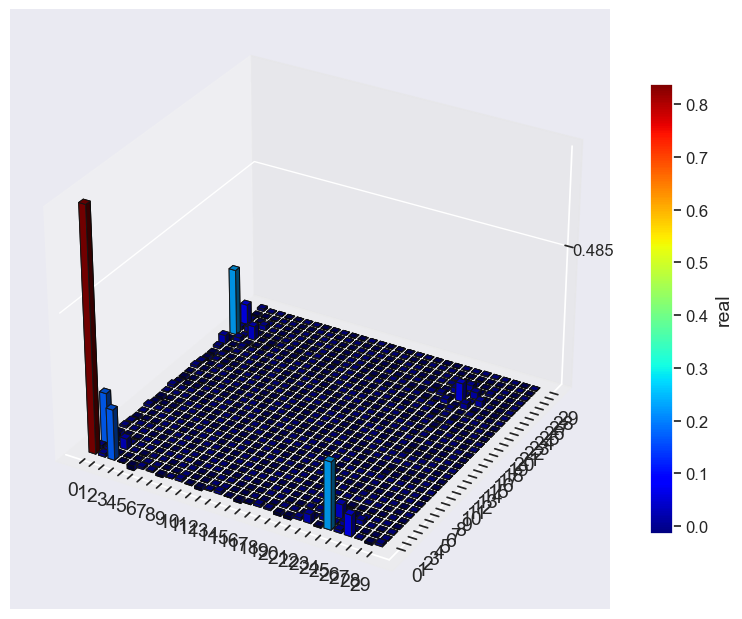

In [87]:
def MLE_reconstruct(measurements, thetas, N_cutoff=10, n_bins=50, max_iter=10, xmax=6):
    
    bin_edges, bin_centers = bins(xmax, n_bins)
    unique_theta = np.unique(thetas)
    M = unique_theta.size
    
    sinogram = get_counts(bin_edges, measurements.reshape(M, -1), unique_theta)
    
    # precompute POVMs for each angle
    povms = {
        theta: quadrature_povm(bin_centers, theta, N_cutoff)
        for theta in unique_theta
    }

    rho = qt.qeye(N_cutoff).unit() 
    
    for iter in tqdm(range(max_iter), desc="MLE Iterations", leave=True):
        R = qt.Qobj(np.zeros((N_cutoff, N_cutoff), dtype=complex))
        for i, theta in enumerate(unique_theta):
            for k, count in enumerate(sinogram[i]):
                if count == 0:
                    continue
                # Get the POVMs for the current theta
                projection = povms[theta][k]
                R += count * R_i(projection, rho)
            # Update the density matrix using the MLE formula
            rho = update_density_matrix(rho, R)
        # Normalize the density matrix
        rho = rho / np.real(rho.tr())
    return rho

N_cutoff = 30
recon = MLE_reconstruct(measurements, thetas, N_cutoff=N_cutoff, n_bins=100, max_iter=100, xmax=8)
qt.matrix_histogram(recon.full())

Text(0.5, 0.98, 'Wigner Functions of Reconstructed and Ground Truth States')

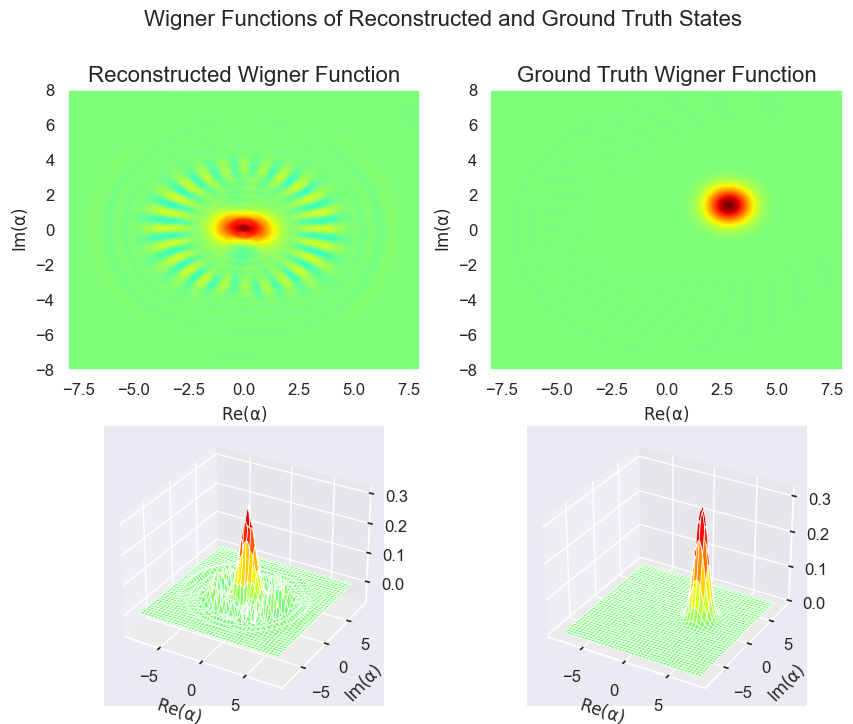

In [76]:
fig = plt.figure(figsize=(10, 8))

cmap = "jet"
xvec = np.linspace(-8, 8, 200)
yvec = np.linspace(-8, 8, 200)
method = "laguerre"

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223, projection="3d")
ax4 = fig.add_subplot(224, projection="3d")
qt.plot_wigner(recon, fig=fig, ax=ax1, cmap=cmap, xvec=xvec, yvec=yvec, projection="2d", method=method)
qt.plot_wigner(groundtruth, fig=fig, ax=ax2, cmap=cmap, xvec=xvec, yvec=yvec, projection="2d", method=method)
qt.plot_wigner(recon, fig=fig, ax=ax3, cmap=cmap, xvec=xvec, yvec=yvec, projection="3d", method=method)
qt.plot_wigner(groundtruth, fig=fig, ax=ax4, cmap=cmap, xvec=xvec, yvec=yvec, projection="3d", method=method)


ax1.set_title("Reconstructed Wigner Function")
ax2.set_title("Ground Truth Wigner Function")

fig.suptitle("Wigner Functions of Reconstructed and Ground Truth States", fontsize=16)


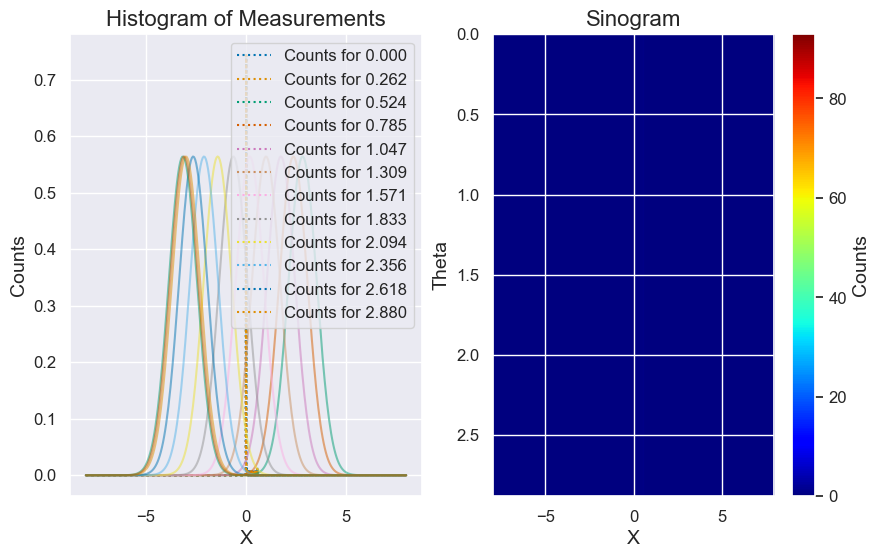

In [91]:
b, c = bins(8, 2000)

unique_theta = np.unique(thetas); 
# print("Unique thetas:", unique_theta)
X = measurements.reshape(len(unique_theta), -1)
sinogram = get_counts(b, X, unique_theta)

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(c, sinogram.T / np.sum(sinogram, axis=1, keepdims=True).T, linestyle=':', markersize=3, label=[f'Counts for {theta:.3f}' for theta in unique_theta])
ax[0].plot(np.linspace(-8, 8, X.shape[1]), X.T, alpha=0.5)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Counts')
ax[0].set_title('Histogram of Measurements')
ax[0].legend()

image = ax[1].imshow(sinogram, aspect='auto', extent=[b[0], b[-1], unique_theta[-1], unique_theta[0]], origin="lower", cmap="jet")
ax[1].set_xlabel('X')
ax[1].set_ylabel('Theta')
ax[1].set_title('Sinogram')
fig.colorbar(image, ax=ax[1], label='Counts')

In [30]:
def quadrature_operator(N : int = 50, theta : float = 0.0) -> qt.Qobj:
    """Generate the quadrature operator for a given angle theta.

    Args:
        N (int): Dimension of the truncated Hilbert space.
        theta (float): Angle in radians for the quadrature operator.
    Returns:
        qt.Qobj: The quadrature operator corresponding to the angle theta.
    """
    a = qt.destroy(N)
    term = a * np.exp(-1j * theta)
    
    return (term + term.dag()) / np.sqrt(2)
        

def build_bins(N, thetas, n_bins=60, x_edges=None, tol=1e-12):
    """Build bins for the quadrature operator eigenstates based on the provided angles.

    Args:
        N (int): Dimension of the Hilbert space.
        thetas (ndarray): Array of angles in radians for which to compute the quadrature operators.
        n_bins (int, optional): Number of bins to create for the eigenvalues. Defaults to 60.
        x_edges (ndarray, optional): Edges for the bins. If `None`, they will be calculated based on the eigenvalues. 

    Returns:
        povms: List of POVMs (Positive Operator-Valued Measures) corresponding to the quadrature operators.
        x_edges: Edges of the bins.
        spectra: List of eigenvalues and eigenvectors for each quadrature operator. 
    """
    spectra = [quadrature_operator(N, theta).eigenstates() for theta in thetas]
    if x_edges is None: # If no edges are provided, calculate them based on the eigenvalues
        # Find the minimum and maximum eigenvalues across all spectra
        xmin = min(e.min() for e, _ in spectra)
        xmax = max(e.max() for e, _ in spectra) 
        pad = 1e-9 # Padding to avoid numerical issues
        x_edges = np.linspace(xmin - pad, xmax + pad, n_bins + 1) 
    
    povms = [] 
    for evals, evecs in tqdm(spectra, desc="Building bins", total=len(spectra)): 
        bin_indices = np.digitize(evals, x_edges) - 1  # -1 to convert to zero-based index
        E_bins = [qt.Qobj(np.zeros((N,N), dtype=np.complex128)) for _ in range(n_bins)] # Initialize bins with zero matrices
        # Fill the bins with the eigenvectors
        for i, bin in enumerate(bin_indices):
            if bin < 0: bin = 0 # Ensure bin index is within bounds
            if bin >= n_bins: bin = n_bins - 1 # Ensure bin index is within bounds
            E_bins[bin] += evecs[i] * evecs[i].dag() 
        povms.append(E_bins)
    return povms, x_edges, spectra

povms, edges, spectra = build_bins(N=50, thetas=thetas, n_bins=60)
len(povms), len(povms[0]), len(edges), len(spectra), len(spectra[0][0]), len(spectra[0][1])

Building bins:   0%|          | 0/1212 [00:00<?, ?it/s]

(1212, 60, 61, 1212, 50, 50)

In [ ]:
def bin_samples(samples, thetas, x_edges, tol=1e-9):
    """This function takes samples and thetas, and bins them into quadrature bins defined by x_edges.

    Args:
        samples (ndarray): Array of samples to be binned.
        thetas (ndarray): Array of angles corresponding to the quadrature measurements.
        x_edges (ndarray): Edges of the bins for the quadrature measurements.
        tol (flaot, optional): tolerance. Defaults to 1e-9.
    Returns:
        counts (ndarray): 2D array where each row corresponds to a theta and each column corresponds to a bin defined by x_edges. The values are the counts of samples in each bin.
    Raises:
        ValueError: If any angle in `thetas` is not close to the corresponding angle in `thetas` within the specified tolerance.
    """
    
    thetas = np.asarray(thetas)
    n_thetas = len(thetas)
    n_bins = len(x_edges) - 1
    counts = np.zeros((n_thetas, n_bins), dtype=int)
    
    for X, th in zip(samples, thetas):
        # Find the bin index for each sample
        idx = np.argmin(np.abs(thetas - th))
        if np.abs(th - thetas[idx]) > tol:
            raise ValueError(f"Angle {th} not close to any theta in thetas. Found {thetas[idx]} instead.")
        
        # Digitize the samples into bins
        bin_indices = np.digitize(X, x_edges) - 1
        b = np.clip(bin_indices, 0, n_bins - 1)  # Ensure indices are within bounds
        counts[idx, b] += 1  # Increment the count for the corresponding bin
    return counts

sinogram = bin_samples(measurements, thetas, edges)
sinogram.shape, (sinogram.sum(axis=1) > 0).sum(), (sinogram.sum(axis=0) > 0).sum()


((1212, 60), np.int64(6), np.int64(4))

In [ ]:


def prob(rho, povm):
    """Construct the P from the density matrix rho and POVMs."""
    return np.real((rho * povm).tr())

In [ ]:
def MLE_binned(X, thetas, N=50, num_bins=60, max_iters=10, tol=1e-9):
    bins, x_edges, spectra = build_bins(N, thetas, n_bins=num_bins)
    n_thetas = len(thetas)
    

In [19]:
# def MLE_binned(counts, povms, n_iter=100, eps=1e-12, verbose=True):
#     """Maximum Likelihood Estimation for binned measurements.

#     Args:
#         counts (ndarray): Binned counts of measurements.
#         povms (list): List of POVM operators for each bin.
#         n_iter (int, optional): Number of iterations for the MLE algorithm. Defaults to 100.
#         eps (float, optional): Small value to avoid division by zero. Defaults to 1e-12.
#         verbose (bool, optional): If True, print progress. Defaults to False.
#     """
#     n_thetas, n_bins = counts.shape
#     N = povms[0][0].shape[0]  # Dimension of the Hilbert space
#     rho = qt.qeye(N) / N  # Initial guess: uniform density matrix
#     tot = counts.sum()  # Total number of counts across all bins
#     like_history = [] # Store likelihood history for convergence analysis
#     if verbose:
#         print(f"Starting MLE with {n_iter} iterations and {tot} total counts.")
#     # Iterate to update the density matrix

#     for _ in trange(n_iter, desc="MLE Iterations"):
#         # P = np.zeros_like(counts, dtype=float)  # Initialize the probability matrix
#         # for t in tqdm(range(n_thetas), desc="Theta Loop", leave=False):
#         #     # Calculate the probabilities for each bin using the POVMs
#         #     for b in tqdm(range(n_bins), desc="Bin Loop", leave=False):
#         #         P[t, b] = np.real((rho * povms[t][b]).tr())  # Calculate the probability for each bin
#         # P = np.maximum(P, eps)  # Avoid division by zero
        
#         # Update the density matrix using the counts and probabilities
#         R = qt.Qobj(np.zeros((N,N), dtype=np.complex128), dims=[[N], [N]])
#         for t in trange(n_thetas, desc="Theta Loop", leave=False):
#             for b in trange(n_bins, desc="Bin Loop", leave=False):
#                 if counts[t, b] > 0:
#                     P = np.clip(a=prob(rho, povms[t][b]), a_min=eps, a_max=None)
#                     R += counts[t, b] * povms[t][b] / P
#         R = R / tot  # Normalize the operator
#         rho = update_density_matrix(rho, R)
#         # ll = np.sum(counts * np.log(P))
#         # like_history.append(ll)
#     return rho, np.array(like_history)

# rho, hist = MLE_binned(counts=counts, povms=povms, n_iter=10, eps=1e-12, verbose=True)